In [2]:
import sys
import os
sys.path.append('../')
from data_loader import DataLoader
import random
from feature_selector import BaselineSelector
from feature_selector import AnalysisSelector
from feature_selector import FeatureExtractor
from utils import parse_config_features
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import configparser
import re

In [3]:
config = configparser.ConfigParser()
config.read('../config.ini')

# all features of one epoch
X = pd.read_csv(os.path.join('..', config['Data']['features_path']))
# labels of one epoch
y = np.load(os.path.join('..', config['Data']['labels_path']))
# participant ids of one epoch
participants = np.load(os.path.join('..', config['Data']['par_ids_path']))

# drop ids
X = X.drop(X.columns[0], axis=1)
# append participants labels to find means per person
X['participant'] = participants
X['label'] = y

In [9]:
means = X.groupby(['participant', 'label']).mean()
means.head(88)
means.to_csv("obrisi.csv")

list(means['hjorth_activity_alpha_9'])

[10.740362387060749,
 40.612154141939286,
 55.566059910934364,
 9.608498754066899,
 14.46826725827449,
 59.16221122834282,
 11.417556456538353,
 16.9625298396394,
 40.00891997010101,
 21.491272087549305,
 52.191677366136936,
 27.13224989979088,
 27.189827466132854,
 12.395116093517183,
 49.39368881386835,
 10.991646426785955,
 18.76116688928985,
 34.41011517500534,
 20.652000203438718,
 14.021588275063234,
 14.584848953865896,
 21.718191122070696,
 29.379528496319004,
 15.013844552511713,
 133.5467162704842,
 18.700050384460315,
 19.21206494480486,
 12.128335238525246,
 17.49450251083573,
 26.65340572367607,
 54.74385067271486,
 41.75233241117244,
 15.730964255363597,
 13.31886439746389,
 10.805557796467689,
 43.90889719885137,
 91.06513943252514,
 50.309515419313485,
 154.89023334878894,
 97.4588043918474,
 53.74869795601934,
 79.8818811107758,
 18.142510819375723,
 132.59259347486798,
 22.387950182868433,
 111.26858888353968,
 70.37533380923574,
 86.15318244694971,
 140.6563705466411

In [5]:
cols = list(means.columns)

In [6]:
C_participants = means.loc[means.index.get_level_values('label') == 0].reset_index()
A_participants = means.loc[means.index.get_level_values('label') == 1].reset_index()
B_participants = means.loc[means.index.get_level_values('label') == 2].reset_index()

In [7]:
def get_outlier_ids(outliers, means, label):
    lbl_to_int = {'C':0, 'A':1, 'B':2}
    indexes = list(outliers[~outliers[label].isna()].index)

    # convert index to par id
    new_means = means.reset_index()
    start_idx = {}
    for index, row in new_means.iterrows():
        if row['label'] not in start_idx:
            start_idx[row['label']] = index
    
    ids = []
    for idx in indexes:
        ids.append(idx + start_idx[lbl_to_int[label]])
    
    return ids

In [8]:
def get_outliers(df):
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    IQR = q3 - q1
    outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]

    return outliers

In [9]:
def get_top_features(n_top=None):
    top_features = []
    with open('mutual_info.txt', 'r') as file:
        for line in file:
            ft = line.strip().split(' ')[0]
            top_features.append((line.strip()).split(' ')[0])

    if n_top:
        top_features = top_features[:n_top]
    return top_features

In [10]:
all_outliers = {}
top_features = get_top_features(5)
top_features

['hjorth_activity_alpha_9',
 'hjorth_activity_alpha_14',
 'hjorth_activity_beta_9',
 'hjorth_activity_alpha_8',
 'hjorth_complexity_alpha_9']

In [11]:
for charac in range(24):

    col = charac*19
    for i in range(4):
        for j in range(5):
            ### plot last subplot empty
            if cols[col] in top_features:
                one_ch = {'C': list(C_participants[cols[col]]), 'A': list(A_participants[cols[col]]), 'B': list(B_participants[cols[col]])}
                ### make dict same length by adding nan
                max_len = max([len(one_ch['C']), len(one_ch['A']), len(one_ch['B'])])
                for key in one_ch.keys():
                    one_ch[key] += [np.nan]*(max_len-len(one_ch[key]))
                one_ch_df = pd.DataFrame(one_ch)

                outliers = get_outliers(one_ch_df)
                outlier_ids = []
                outlier_ids.extend(get_outlier_ids(outliers, means, 'C'))
                outlier_ids.extend(get_outlier_ids(outliers, means, 'A'))
                outlier_ids.extend(get_outlier_ids(outliers, means, 'B'))
                
                for oid in outlier_ids:
                    if oid in all_outliers:
                        all_outliers[oid] += 1
                    else:
                        all_outliers[oid] = 1

            col += 1

In [14]:
all_outliers = dict(sorted(all_outliers.items(), key=lambda item: item[1]))
all_outliers

{5: 1,
 40: 1,
 55: 1,
 25: 1,
 29: 1,
 31: 1,
 35: 1,
 85: 1,
 74: 2,
 24: 3,
 63: 4,
 79: 5}

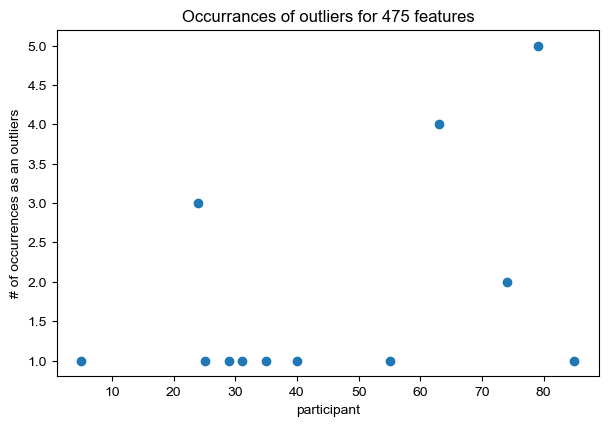

In [13]:
keys, vals = all_outliers.keys(), all_outliers.values()
vals = np.array(list(vals))
vals.sort
fig, ax = plt.subplots(figsize=(7, 4.5))
plt.grid()
sns.set(style='darkgrid')
plt.grid()
plt.scatter(keys, vals)
plt.ylabel("# of occurrences as an outliers")
plt.xlabel("participant")
plt.title("Occurrances of outliers for 475 features")
#plt.ylim([0, 2000])
plt.savefig("outliers_all_features.png")

In [113]:
keys

dict_keys([81, 28, 42, 77, 64, 51, 33, 67, 15, 56, 34, 6, 18, 58, 60, 82, 9, 46, 41, 71, 12, 50, 86, 76, 70, 48, 11, 39, 0, 40, 14, 37, 57, 62, 43, 54, 22, 78, 53, 59, 44, 17, 61, 16, 10, 4, 69, 74, 32, 3, 87, 20, 49, 72, 1, 13, 73, 65, 8, 45, 52, 38, 36, 75, 83, 24, 63, 47, 26, 79, 66, 7, 21, 2, 5, 84, 68, 35, 25, 30, 29, 31, 85, 55])